In [18]:
#step 1 import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets 


In [19]:

# Step 2Prepare the datasets
noise = transforms.Lambda(lambda x: transforms.ToTensor()(x) + 0.5*torch.randn_like(transforms.ToTensor()(x)).clamp(-1, 1))

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=noise, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# Create data loaders
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [20]:
device=torch.device("cuda" if torch.cuda.is_available else  "cpu")

In [21]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Flatten(),
            nn.Linear(64*4*4, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(64, 16),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 64*4*4),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Unflatten(dim=1, unflattened_size=(64, 4, 4)),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [22]:
learning_rate = 0.0002
 
beta1 = 0.5 #For Adam optimizers
# step 5 instatiate model, criterion , optimizer
model=Autoencoder(0.2)
criterion=nn.MSELoss()

optimizer=optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1,0.999) )

In [28]:
import torch.nn.functional as F
# Step 6: Train the network
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        images, _ = data
        # Resize images to match the model's input size
        images = F.interpolate(images, size=(32, 32), mode='bilinear', align_corners=False)
        # zero grad
        optimizer.zero_grad()
        # forward, backward, update
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    running_loss /= len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, running_loss))  # Print training loss for the epoch


Epoch: 1 	Training Loss: 0.610211
Epoch: 2 	Training Loss: 0.568494
Epoch: 3 	Training Loss: 0.547069
Epoch: 4 	Training Loss: 0.533618
Epoch: 5 	Training Loss: 0.526057
Epoch: 6 	Training Loss: 0.521054
Epoch: 7 	Training Loss: 0.516303
Epoch: 8 	Training Loss: 0.512229
Epoch: 9 	Training Loss: 0.509144
Epoch: 10 	Training Loss: 0.506246


In [24]:
# Set mode to evaluation
model.eval()

test_loss = 0.0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, _ = data
        images = images
        outputs = model(images)
        
        # Resize target tensor to match the size of the input tensor
        target = F.interpolate(images, size=outputs.shape[-2:], mode='nearest')
        
        # Calculate the loss
        loss = criterion(outputs, target)
        test_loss += loss.item() * images.size(0)

test_loss /= len(test_loader.dataset)

# Print the test loss
print('Test Loss: {:.6f}'.format(test_loss))


Test Loss: 0.074321


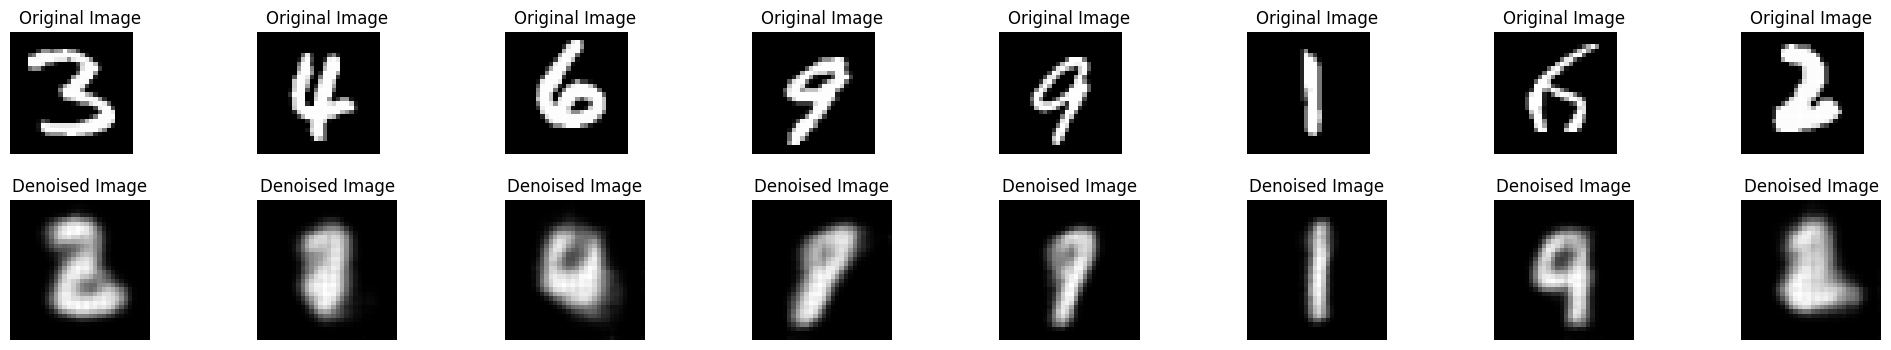

In [27]:
import matplotlib.pyplot as plt
import random
random.seed(999)
torch.manual_seed(999)

# Get a batch of test images
dataiter = iter(test_loader)
images, _ = next(iter(test_loader))


# Pass the test images through the autoencoder
denoised = model(images)

# Plot the original images and their denoised counterparts
fig, axes = plt.subplots(nrows=2, ncols=8, sharex=True, sharey=True, figsize=(25,4))

# Plot the original images
for i in range(8):
    axes[0,i].imshow(images[i].numpy().squeeze(), cmap='gray')
    axes[0,i].set_title('Original Image')
    axes[0,i].axis('off')

# Plot the denoised images
for i in range(8):
    axes[1,i].imshow(denoised[i].detach().numpy().squeeze(), cmap='gray')
    axes[1,i].set_title('Denoised Image')
    axes[1,i].axis('off')

plt.show()
